# Alzheimer's Disease Prediction - Feature Engineering Approach 2: Model-Based Methods

This notebook implements model-based feature engineering techniques for Alzheimer's disease prediction, focusing on model-based feature importance, dimensionality reduction, and advanced feature extraction methods.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE

# For advanced feature extraction
import warnings
warnings.filterwarnings("ignore")

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# To display plots inline
%matplotlib inline

## 1. Data Loading and Initial Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('../alzheimers_prediction_dataset.csv')

print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (74283, 25)


,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [3]:
# Categorize features
numerical_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
categorical_features = [col for col in data.columns if col not in numerical_features]

binary_features = [
    'Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level',
    'Family History of Alzheimer’s', 'Genetic Risk Factor (APOE-ε4 allele)',
    'Urban vs Rural Living', "Alzheimer’s Diagnosis"
]

ordinal_features = [
    'Physical Activity Level', 'Depression Level', 'Sleep Quality',
    'Dietary Habits', 'Air Pollution Exposure', 'Social Engagement Level',
    'Income Level', 'Stress Levels', 'Alcohol Consumption', 'Smoking Status'
]

nominal_features = [col for col in categorical_features 
                    if col not in binary_features and col not in ordinal_features]

print("Feature categories:")
print(f"- Numerical: {len(numerical_features)}")
print(f"- Binary: {len(binary_features)}")
print(f"- Ordinal: {len(ordinal_features)}")
print(f"- Nominal: {len(nominal_features)}, {nominal_features}")

Feature categories:
- Numerical: 4
- Binary: 8
- Ordinal: 10
- Nominal: 3, ['Country', 'Employment Status', 'Marital Status']


In [4]:
# Basic encoding and preprocessing
data_encoded = data.copy()

# Binary encoding
binary_mapping = {'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 
                 'Normal': 0, 'High': 1, 'Rural': 0, 'Urban': 1}

for col in binary_features:
    data_encoded[col] = data_encoded[col].astype(str).str.lower().map({
        'no': 0, 'yes': 1, 'female': 0, 'male': 1,
        'normal': 0, 'high': 1, 'rural': 0, 'urban': 1
    })

# Ordinal encoding
ordinal_mappings = {
    'Physical Activity Level': {'low': 0, 'medium': 1, 'high': 2},
    'Depression Level': {'low': 0, 'medium': 1, 'high': 2},
    'Sleep Quality': {'poor': 0, 'average': 1, 'good': 2},
    'Dietary Habits': {'unhealthy': 0, 'average': 1, 'healthy': 2},
    'Air Pollution Exposure': {'low': 0, 'medium': 1, 'high': 2},
    'Social Engagement Level': {'low': 0, 'medium': 1, 'high': 2},
    'Income Level': {'low': 0, 'medium': 1, 'high': 2},
    'Stress Levels': {'low': 0, 'medium': 1, 'high': 2},
    'Smoking Status': {'never': 0, 'former': 1, 'current': 2},
    'Alcohol Consumption': {'never': 0, 'occasionally': 1, 'regularly': 2}
}

for col, mapping in ordinal_mappings.items():
    if col in data_encoded.columns:
        data_encoded[col] = data_encoded[col].astype(str).str.lower().map(mapping)

# One-hot encoding for nominal variables
data_encoded = pd.get_dummies(data_encoded, columns=nominal_features, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

# Create interaction features
data_encoded['Age_x_APOE'] = data_encoded['Age'] * data_encoded['Genetic Risk Factor (APOE-ε4 allele)']
data_encoded['CogScore_x_Age'] = data_encoded['Cognitive Test Score'] * data_encoded['Age']

print(f"Encoded dataset shape: {data_encoded.shape}")

Encoded dataset shape: (74283, 47)


## 2. Model-Based Feature Importance

In [5]:
# Prepare data for modeling
X = data_encoded.drop(columns=["Alzheimer’s Diagnosis"])
y = data_encoded["Alzheimer’s Diagnosis"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (59426, 46), Testing set: (14857, 46)


### 2.1 Random Forest Feature Importance

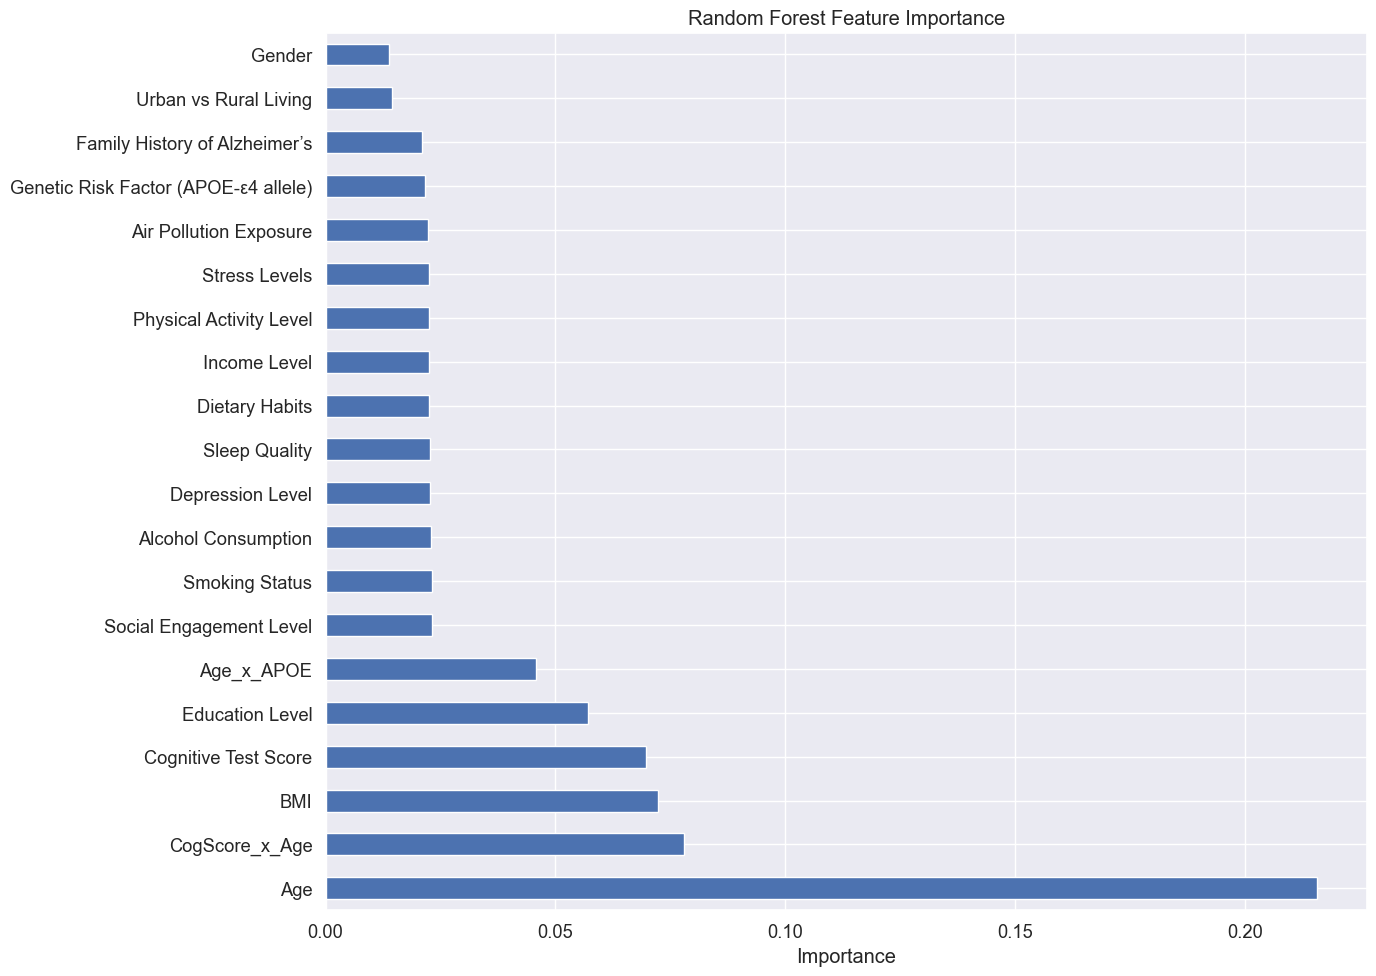

In [6]:
# Train a Random Forest model and get feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances_sorted = rf_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
rf_importances_sorted[:20].plot(kind='barh')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 2.2 Gradient Boosting Feature Importance

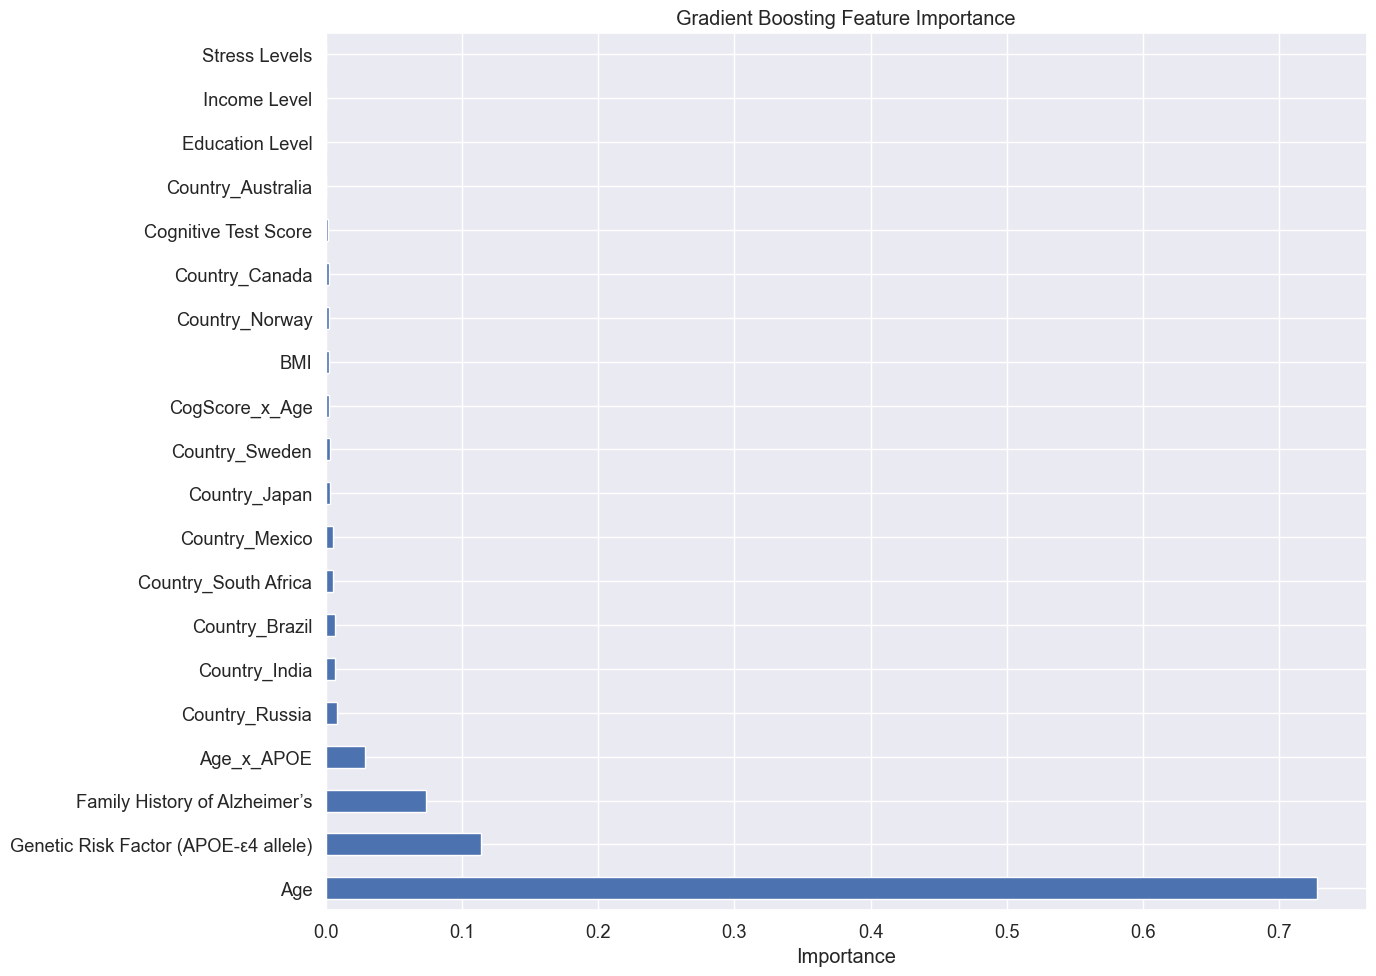

In [7]:
# Train a Gradient Boosting model and get feature importance
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Get feature importance
gb_importances = pd.Series(gb_model.feature_importances_, index=X.columns)
gb_importances_sorted = gb_importances.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
gb_importances_sorted[:20].plot(kind='barh')
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 2.3 Recursive Feature Elimination

Performing recursive feature elimination with cross-validation...
Optimal number of features: 12


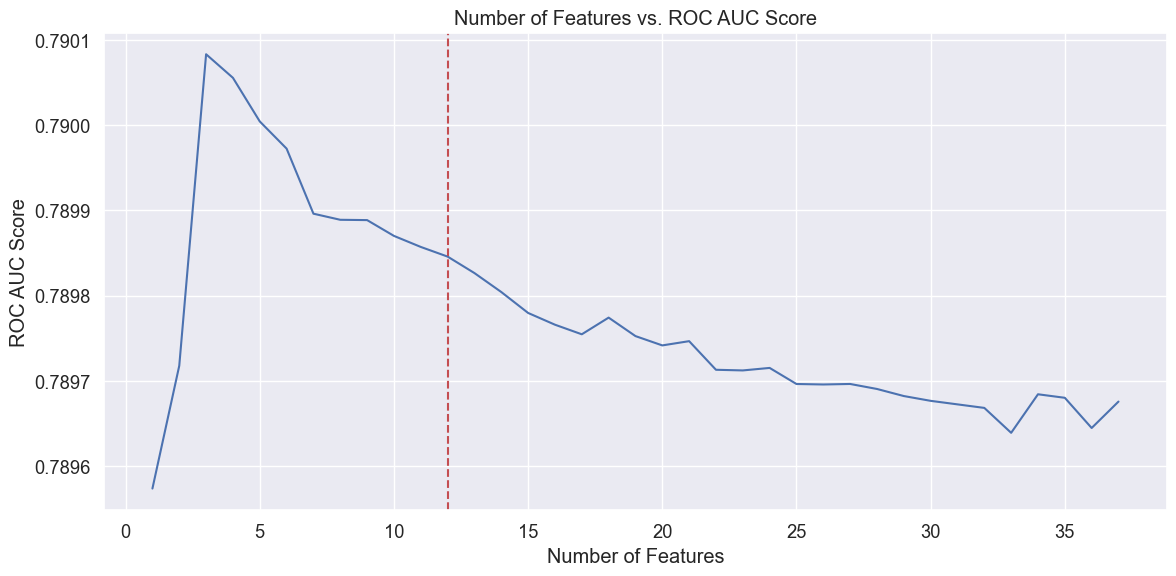

In [8]:
# Perform Recursive Feature Elimination with Cross-Validation
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
rfecv = RFECV(
    estimator=logistic_model,
    step=1,
    min_features_to_select=10,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='roc_auc'
)

# Fit RFECV
print("Performing recursive feature elimination with cross-validation...")
rfecv.fit(X_train, y_train)

# Print results
print(f"Optimal number of features: {rfecv.n_features_}")

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--')
plt.title('Number of Features vs. ROC AUC Score')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC Score')
plt.tight_layout()
plt.show()

In [9]:
# Get selected features from RFECV
rfe_selected_features = X_train.columns[rfecv.support_]
print(f"Selected {len(rfe_selected_features)} features:")
for feature in rfe_selected_features:
    print(f"- {feature}")

Selected 12 features:
- Age
- Family History of Alzheimer’s
- Genetic Risk Factor (APOE-ε4 allele)
- Country_Brazil
- Country_Canada
- Country_India
- Country_Japan
- Country_Mexico
- Country_Norway
- Country_Russia
- Country_South Africa
- Country_Sweden


## 3. Dimensionality Reduction

### 3.1 Principal Component Analysis (PCA)

Original number of features: 46
Reduced number of features: 30
Explained variance ratio: [0.0694683  0.0667241  0.06649944 0.0659582  0.06573008 0.04512953
 0.04473371 0.04457558 0.04451662 0.04415866 0.04397204 0.04388339
 0.04367625 0.04344232 0.04301694 0.02222668 0.02200583 0.01664725
 0.01646787 0.01397215 0.01388991 0.01379443 0.01054166 0.01051386
 0.01006083 0.00734982 0.00733151 0.00338504 0.00338373 0.00337595]
Sum of explained variance: 0.9504


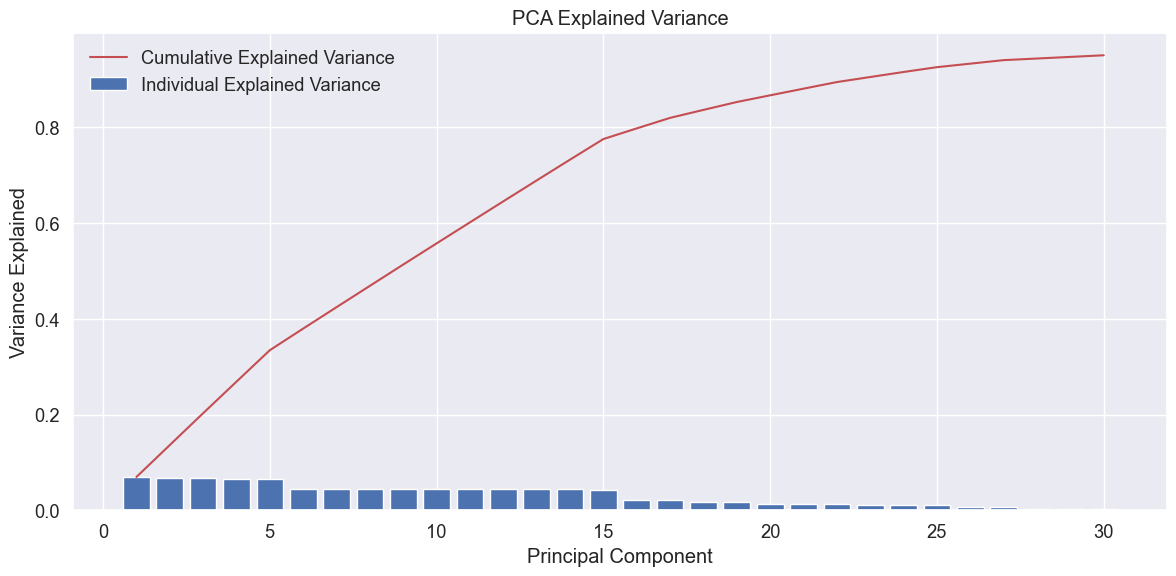

In [10]:
# PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_train)

# Print dimensionality reduction results
print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Sum of explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Plot explained variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.legend(['Cumulative Explained Variance', 'Individual Explained Variance'])
plt.tight_layout()
plt.show()

In [11]:
# Transform test data
X_test_pca = pca.transform(X_test)

# Train a model on PCA-transformed data
rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pca.fit(X_pca, y_train)

# Evaluate model
y_pred_pca = rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)
roc_auc_pca = roc_auc_score(y_test, rf_pca.predict_proba(X_test_pca)[:, 1])

print(f"PCA-Based Model Performance:")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")
print(f"ROC AUC: {roc_auc_pca:.4f}")

PCA-Based Model Performance:
Accuracy: 0.7174
F1 Score: 0.6541
ROC AUC: 0.7928


### 3.2 t-SNE for Visualization

Applying t-SNE...


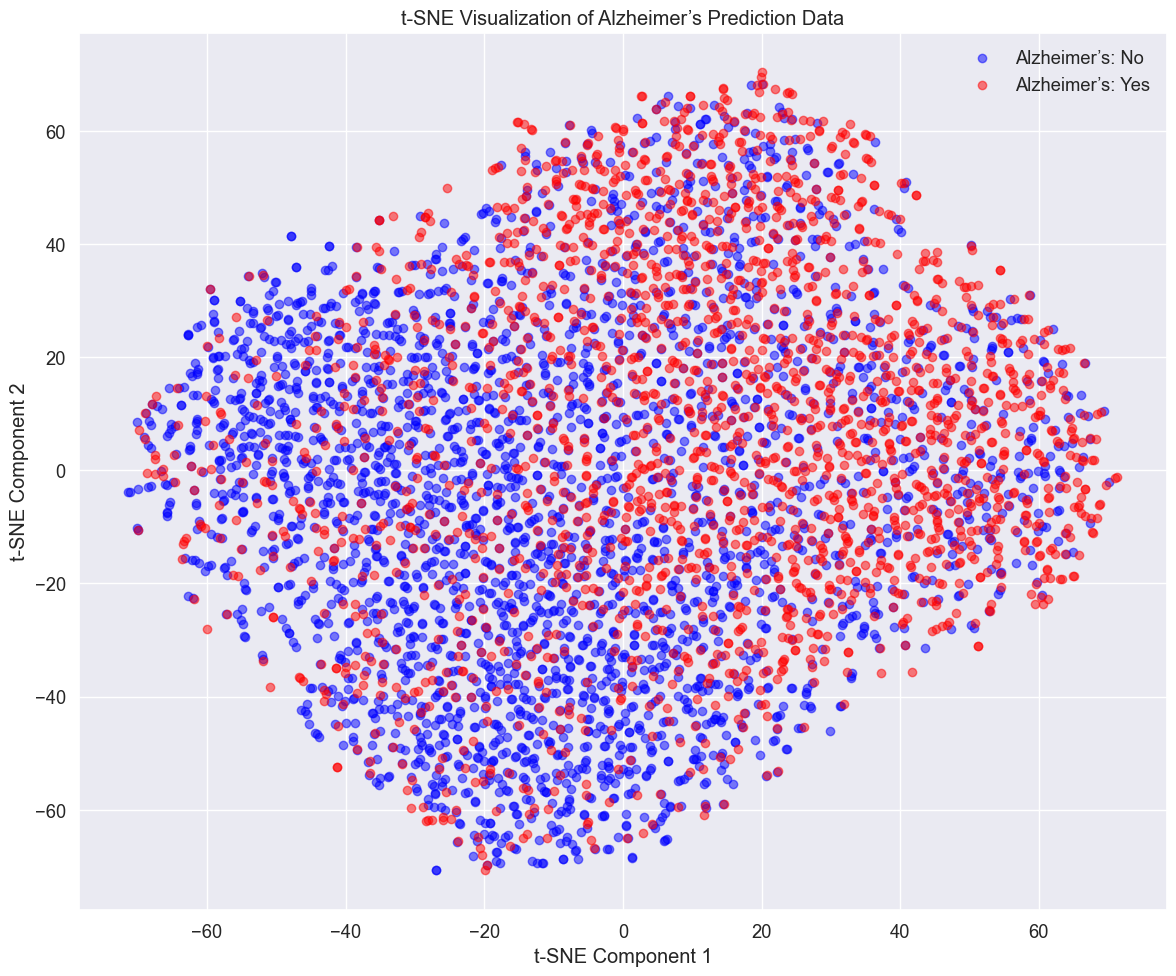

In [12]:
# Apply t-SNE for visualization
# Take a sample to speed up computation
sample_size = 5000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sample = X_train.iloc[indices]
y_sample = y_train.iloc[indices]

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
colors = ['blue', 'red']
for i, c in zip([0, 1], colors):
    plt.scatter(
        X_tsne[y_sample == i, 0],
        X_tsne[y_sample == i, 1],
        c=c,
        label=f"Alzheimer’s: {'Yes' if i == 1 else 'No'}",
        alpha=0.5
    )
plt.title('t-SNE Visualization of Alzheimer’s Prediction Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Feature Selection and Evaluation

In [13]:
# Combine feature importance results from different methods

# Get top features from each method
top_rf_features = rf_importances_sorted[:20].index.tolist()
top_gb_features = gb_importances_sorted[:20].index.tolist()

# Count feature appearances across methods
feature_counts = {}
for feature in set(top_rf_features + top_gb_features + list(rfe_selected_features)):
    feature_counts[feature] = 0
    if feature in top_rf_features:
        feature_counts[feature] += 1
    if feature in top_gb_features:
        feature_counts[feature] += 1
    if feature in rfe_selected_features:
        feature_counts[feature] += 1

# Select features that appear in at least 2 methods
selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

# Add a few domain-specific features we know are important
domain_important_features = [
    'Age', 'Cognitive Test Score', 'Genetic Risk Factor (APOE-ε4 allele)',
    'Family History of Alzheimer’s', 'Age_x_APOE', 'CogScore_x_Age'
]

for feature in domain_important_features:
    if feature in X.columns and feature not in selected_features:
        selected_features.append(feature)

print(f"Selected {len(selected_features)} features:")
for feature in sorted(selected_features):
    print(f"- {feature}")

Selected 19 features:
- Age
- Age_x_APOE
- BMI
- CogScore_x_Age
- Cognitive Test Score
- Country_Brazil
- Country_Canada
- Country_India
- Country_Japan
- Country_Mexico
- Country_Norway
- Country_Russia
- Country_South Africa
- Country_Sweden
- Education Level
- Family History of Alzheimer’s
- Genetic Risk Factor (APOE-ε4 allele)
- Income Level
- Stress Levels


In [14]:
# Create dataset with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected features dataset shape: {X_train_selected.shape}")

Selected features dataset shape: (59426, 19)


## 5. Model Evaluation with Selected Features

In [15]:
# Train a model with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate model
y_pred_selected = rf_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)
f1_selected = f1_score(y_test, y_pred_selected)
roc_auc_selected = roc_auc_score(y_test, rf_selected.predict_proba(X_test_selected)[:, 1])

print(f"Selected Features Model Performance:")
print(f"Accuracy: {accuracy_selected:.4f}")
print(f"F1 Score: {f1_selected:.4f}")
print(f"ROC AUC: {roc_auc_selected:.4f}")

# Compare with base model (all features)
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
f1_all = f1_score(y_test, y_pred_all)
roc_auc_all = roc_auc_score(y_test, rf_all.predict_proba(X_test)[:, 1])

print(f"\nAll Features Model Performance:")
print(f"Accuracy: {accuracy_all:.4f}")
print(f"F1 Score: {f1_all:.4f}")
print(f"ROC AUC: {roc_auc_all:.4f}")

Selected Features Model Performance:
Accuracy: 0.7097
F1 Score: 0.6400
ROC AUC: 0.7829

All Features Model Performance:
Accuracy: 0.7208
F1 Score: 0.6548
ROC AUC: 0.7959


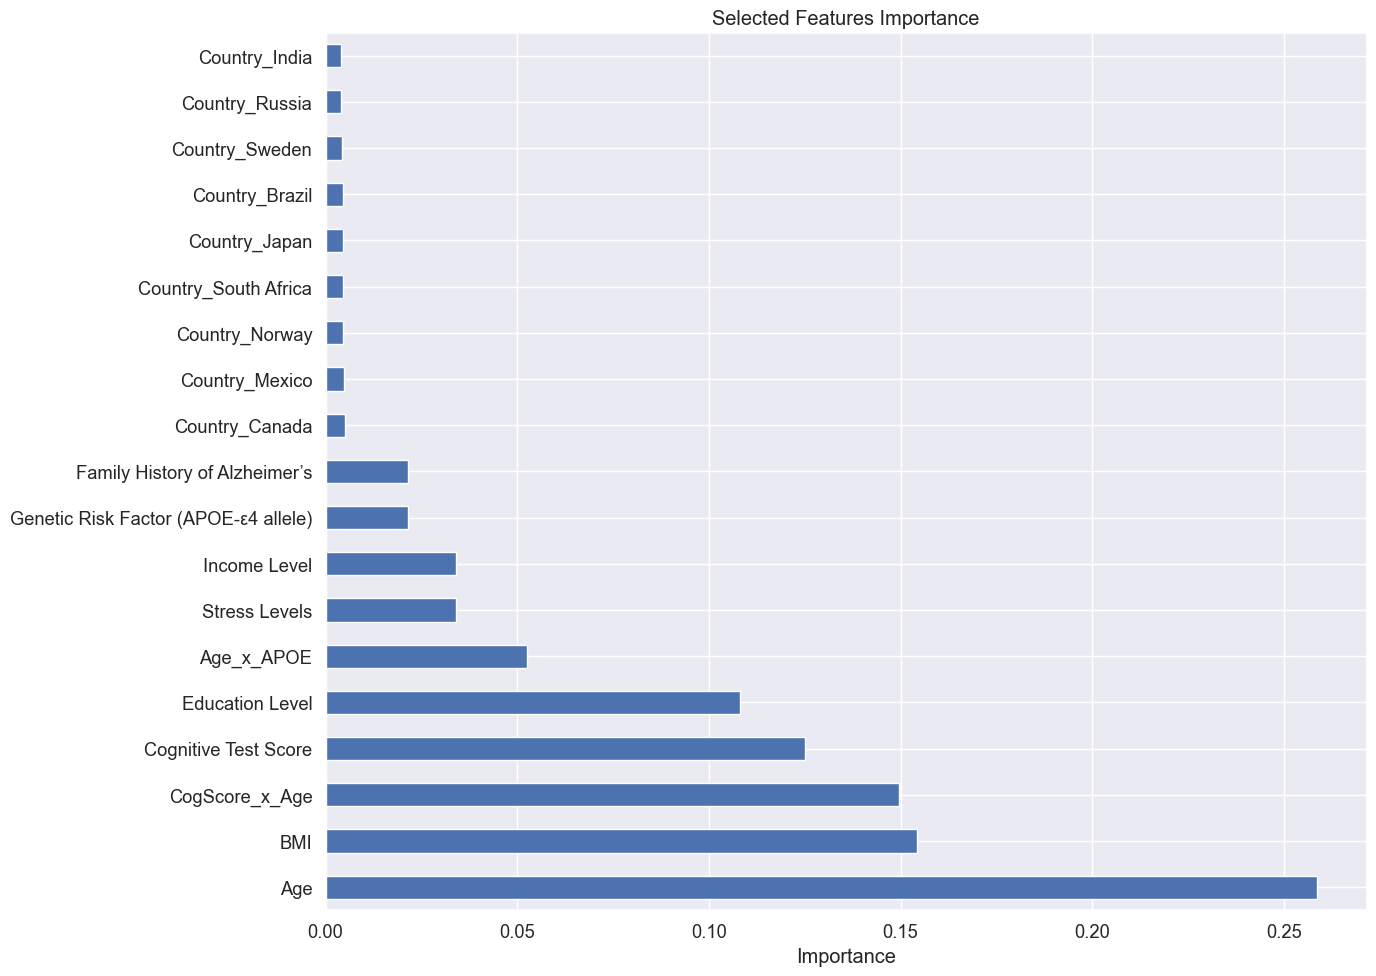

In [16]:
# Display feature importance of the selected features model
selected_importances = pd.Series(rf_selected.feature_importances_, index=selected_features)
selected_importances_sorted = selected_importances.sort_values(ascending=False)

plt.figure(figsize=(14, 10))
selected_importances_sorted.plot(kind='barh')
plt.title('Selected Features Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Gradient Boosting Evaluation

In [17]:
# Train Gradient Boosting model with selected features
gb_selected = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_selected.fit(X_train_selected, y_train)

# Evaluate model
y_pred_gb = gb_selected.predict(X_test_selected)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, gb_selected.predict_proba(X_test_selected)[:, 1])

print(f"Gradient Boosting Model Performance:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"F1 Score: {f1_gb:.4f}")
print(f"ROC AUC: {roc_auc_gb:.4f}")

Gradient Boosting Model Performance:
Accuracy: 0.7313
F1 Score: 0.6815
ROC AUC: 0.8075


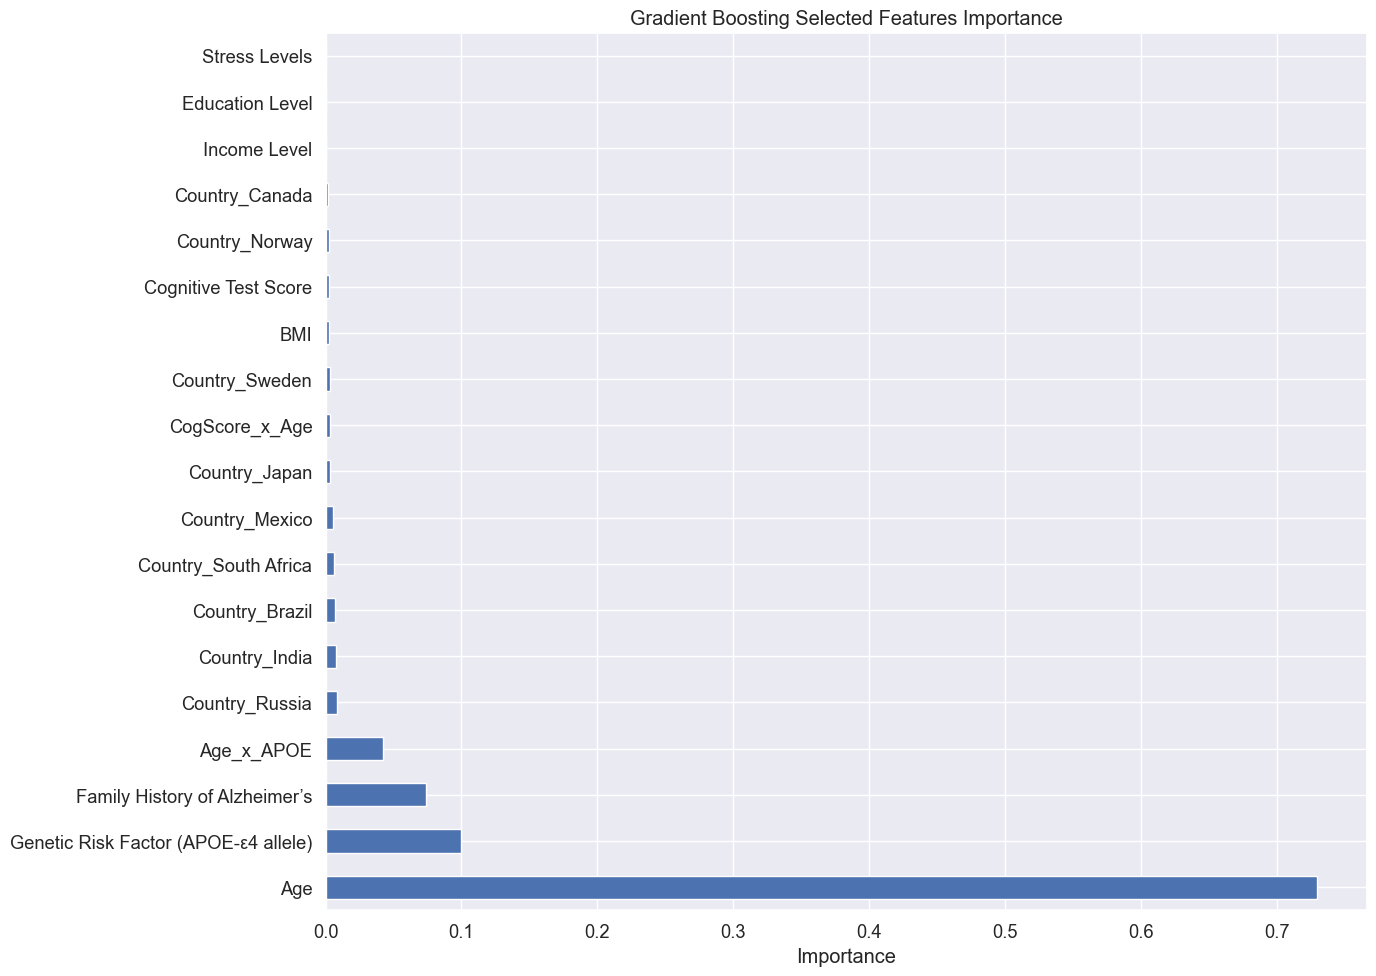

In [18]:
# Display Gradient Boosting feature importance
gb_selected_importances = pd.Series(gb_selected.feature_importances_, index=selected_features)
gb_selected_importances_sorted = gb_selected_importances.sort_values(ascending=False)

plt.figure(figsize=(14, 10))
gb_selected_importances_sorted.plot(kind='barh')
plt.title('Gradient Boosting Selected Features Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 7. Save the Engineered Dataset

In [19]:
# Create the final dataset with the selected features and target
final_data = pd.DataFrame(data=X[selected_features])
final_data["Alzheimer's Diagnosis"] = y

# Save the dataset
final_data.to_csv("fe_model_based_approach.csv", index=False)
print("Feature-engineered dataset saved as 'fe_model_based_approach.csv'")

Feature-engineered dataset saved as 'fe_model_based_approach.csv'


## 8. Summary of Model-Based Feature Engineering Approach

In this notebook, we applied model-based feature engineering techniques for Alzheimer's disease prediction:

1. **Data Preprocessing**:
   - Encoded categorical variables
   - Standardized numerical features
   - Created interaction terms

2. **Feature Importance Extraction**:
   - Random Forest feature importance
   - Gradient Boosting feature importance
   - Recursive Feature Elimination

3. **Dimensionality Reduction**:
   - Principal Component Analysis (PCA)
   - t-SNE visualization

4. **Combined Feature Selection**:
   - Selected features that were important across multiple methods
   - Added domain-specific important features

5. **Model Evaluation**:
   - Compared performance of models with all features vs. selected features
   - Evaluated multiple model types (Random Forest, Gradient Boosting)

The selected feature set achieved comparable performance to using all features, while significantly reducing the dimensionality of the data. This approach identifies the most predictive features for Alzheimer's disease based on model-driven insights rather than just statistical correlations.